## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors: Paul Doucet, Jerry Khidaroo

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hi, are you busy? I am not. What can I do for you? I'm hearing some noises I don't like from under the hood. I need you to make an appointment to Intelligent Auto Solutions. I can do that for you. When do you want to do it? Let's go for tomorrow morning. Okay, hold. They said they can't do it until tomorrow afternoon. Is that okay? Yes, that will have to do. They need to know the details of your vehicle. What is the make? Honda and the model? Pilot Any trim? Um, I think it's a Sport. Is this relevant? They asked, so I asked. Did they have an estimate? One moment ...... They said $80 to inspect. I guess that will have to do, too. Just to reiterate: you wanted to see Intelligent Auto Services tomorrow afternoon about some weird noises, and you're willing to cover the $80 inspection? That is correct. You're the best Just keep signing the checks.",auto-repair-appt-1,0
126,"Hi I'm trying to get my car checked out at INtelligent auto solutions Sure thing, can I get the make model and year? It's a 1997 Honda Civic And what seems to be the issue today? Whenever I go above 60 mph there's a bit of rattling going on That could be one of many things, but a good idea to get it checked out. Yes, I'd like to get it checked out. Okay, and what time is good for you? I'd like tomorrow morning if possible, the sooner the better. Tomorrow morning is available, how does 8am sound? That sounds great. Okay, it may take a few hours, but hopefully you'll be able to pick it up in the afternoon Sure, that's fine. The total cost of the appointment minus repairs would be $55 That's okay, I'll do whatever it takes. Okay, do you know where the store is located at? No, I don't. It's on 9th and Broadway, their number is 702-131-4813 Got it Thanks. Was there anything else I can help you with? No, that's all. Have a good day!",auto-repair-appt-1,0
555,"Hi, can you find tickets for the Aquaman movie? Sure, for what city? Riverside would be best. Sounds good. What time? 9:45 is perfect. Ok. For how many people? 2 people. Did you want to see it in 3D? No thank you. Ok, there is one showing at the Galleria 16 at 9:45 That's not far at all. I'll take that one. The cost is $9 per person plus tax. Ok, great. Are you ready for me to read the information back to you? Yes. Ok, I have purchased tickets at the Galleria 16 in Riverside for the 9:45 showing. Great! Do you need any other information like directions? No, I have the information. Thank you. You're welcome.",movie-tickets-1,1
1260,"My cousin is in town. She loves Mexican food. Can you make a reservation for 2 at Rocco's tacos? Yes of course. For which day and for what time? This Saturday at 7 pm Where would you like to sit? Can we have a table by the window in a non-smoking section? I want to be away from the kitchen, if possible. Alright, let me check Outside seating is also fine as long as its a non-smoking section . The restaurant is all non-smoking. But the window as well as outside tables are reserved for that time. What about 7:30? Is a window or outside table available then? No, but a window table is available at 8 pm. 8 would be too late for us. Hey can you try Pancheros? Sure 7:00 would be best, or maybe 7:30. Still looking for a window or outdoor seating? yes They have a window table available for 7 pm and an outdoor one for 7:30 We prefer 7 pm 7 pm it is. Thank you My pleasure! At 7:00 pm on Saturday, Pancheros will have a window table for you two. Thank you You are welcome",restaurant-table-2,2
902,"Hey Maria. I need you to call Marco's Pizza and place an order for me, please. We're going to have to work late at the office, and I want to make sure everyone is fed. Okay. Do you want the Marco's in Patrick Street Plaza, then? Yeah, that one is the closest. Okay. What kind of pizzas do you want me to order? Let's start with an extra large Pepperoni Magnifico, and a Deluxe Uno. Okay. Should I leave all the default toppings on? Yes-- can you throw in a medium 

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hi, are you busy? I am not. What can I do for you? I'm hearing some noises I don't like from under the hood. I need you to make an appointment to Intelligent Auto Solutions. I can do that for you. When do you want to do it? Let's go for tomorrow morning. Okay, hold. They said they can't do it until tomorrow afternoon. Is that okay? Yes, that will have to do. They need to know the details of your vehicle. What is the make? Honda and the model? Pilot Any trim? Um, I think it's a Sport. Is this relevant? They asked, so I asked. Did they have an estimate? One moment ...... They said $80 to inspect. I guess that will have to do, too. Just to reiterate: you wanted to see Intelligent Auto Services tomorrow afternoon about some weird noises, and you're willing to cover the $80 inspection? That is correct. You're the best Just keep signing the checks.",auto-repair-appt-1,0,hi busy im hearing noises dont like hood need make appointment intelligent auto solutions want lets go tomorrow morning okay hold said cant tomorrow afternoon okay yes need know details vehicle make honda model pilot trim um think sport relevant asked asked estimate one moment said inspect guess reiterate wanted see intelligent auto services tomorrow afternoon weird noises youre willing cover inspection correct youre best keep signing checks
126,"Hi I'm trying to get my car checked out at INtelligent auto solutions Sure thing, can I get the make model and year? It's a 1997 Honda Civic And what seems to be the issue today? Whenever I go above 60 mph there's a bit of rattling going on That could be one of many things, but a good idea to get it checked out. Yes, I'd like to get it checked out. Okay, and what time is good for you? I'd like tomorrow morning if possible, the sooner the better. Tomorrow morning is available, how does 8am sound? That sounds great. Okay, it may take a few hours, but hopefully you'll be able to pick it up in the afternoon Sure, that's fine. The total cost of the appointment minus repairs would be $55 That's okay, I'll do whatever it takes. Okay, do you know where the store is located at? No, I don't. It's on 9th and Broadway, their number is 702-131-4813 Got it Thanks. Was there anything else I can help you with? No, that's all. Have a good day!",auto-repair-appt-1,0,hi im trying get car checked intelligent auto solutions sure thing get make model year honda civic seems issue today whenever go mph theres bit rattling going could one many things good idea get checked yes id like get checked okay time good id like tomorrow morning possible sooner better tomorrow morning available sound sounds great okay may take hours hopefully youll able pick afternoon sure thats fine total cost appointment minus repairs would thats okay ill whatever takes okay know store located dont th broadway number got thanks anything else help thats good day
555,"Hi, can you find tickets for the Aquaman movie? Sure, for what city? Riverside would be best. Sounds good. What time? 9:45 is perfect. Ok. For how many people? 2 people. Did you want to see it in 3D? No thank you. Ok, there is one showing at the Galleria 16 at 9:45 That's not far at all. I'll take that one. The cost is $9 per person plus tax. Ok, great. Are you ready for me to read the information back to you? Yes. Ok, I have purchased tickets at the Galleria 16 in Riverside for the 9:45 showing. Great! Do you need any other information like directions? No, I have the information. Thank you. You're welcome.",movie-tickets-1,1,hi find tickets aquaman movie sure city riverside would best sounds good time perfect ok many people people want see thank ok one showing galleria thats far ill take one cost per person plus tax ok great ready read information back yes ok purchased tickets galleria riverside showing great need information like directions information thank youre welcome


In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hi im trying get car checked intelligent auto solutions sure thing get make model year honda civic seems issue today whenever go mph theres bit rattling going could one many things good idea get checked yes id like get checked okay time good id like tomorrow morning possible sooner better tomorrow morning available sound sounds great okay may take hours hopefully youll able pick afternoon sure thats fine total cost appointment minus repairs would thats okay ill whatever takes okay know store located dont th broadway number got thanks anything else help thats good day',
 'hi find tickets aquaman movie sure city riverside would best sounds good time perfect ok many people people want see thank ok one showing galleria thats far ill take one cost per person plus tax ok great ready read information back yes ok purchased tickets galleria riverside showing great need information like directions information thank youre welcome',
 'cousin town loves mexican food make reservation roccos tacos 

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\tenso

Vocabulary Size: 5888
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('pm', 6), ('want', 7), ('order', 8), ('time', 9), ('thank', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hi', 'busy', 'hearing', 'noises'] -> Target (Y): im
Context (X): ['busy', 'im', 'noises', 'dont'] -> Target (Y): hearing
Context (X): ['im', 'hearing', 'dont', 'like'] -> Target (Y): noises
Context (X): ['hearing', 'noises', 'like', 'hood'] -> Target (Y): dont
Context (X): ['noises', 'dont', 'hood', 'need'] -> Target (Y): like
Context (X): ['dont', 'like', 'need', 'make'] -> Target (Y): hood
Context (X): ['like', 'hood', 'make', 'appointment'] -> Target (Y): need
Context (X): ['hood', 'need', 'appointment', 'intelligent'] -> Target (Y): make
Context (X): ['need', 'make', 'intelligent', 'auto'] -> Target (Y): appointment
Context (X): ['make', 'appointment', 'auto', 'solutions'] -> Target (Y): intelligent
Context (X): ['appointment', 'intelligent', 'solutions', 'want'] -> Target (Y): auto


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 2, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 2, 2, ..., 0, 1, 1],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,pm,want,order,time,thank,tickets,please,one,great,...,nodumb,dumber,geniusyou,adacompliant,displayed,commerce,baldwin,laptop,antico,broccoli,giannis,eaten,chase,hughes,playa
0,0,1,0,2,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,1,4,0,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,4,1,0,1,0,1,2,2,0,2,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,3,0,0,2,6,1,0,2,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,12,0,3,0,5,7,0,0,0,1,9,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,3,3,0,0,2,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
996,0,3,3,1,1,1,0,1,0,2,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
997,0,1,0,0,1,2,0,4,1,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
998,0,2,2,0,2,1,0,0,1,2,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5888)
(250, 5888)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Features Baseline Benchmarking with LinearSVC Classifier

In [22]:
from sklearn.svm import LinearSVC

model_svc_bow = LinearSVC()
cm_svc_bow, pred_svc_bow, f1_svc_bow, report_svc_bow, accuracy_svc_bow = Build_Model(model_svc_bow, X_train_bow, y_train, X_test_bow, y_test)

In [23]:
# Save benchmark output
rows_benchmarks = []
rows_benchmarks.append(["BOW LinearSVC All Features", f1_svc_bow, accuracy_svc_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.62,0.62


In [24]:
from sklearn.metrics import confusion_matrix

cm_svc_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  5,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  9, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  5,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  8, 10,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  7, 19,  0,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  0,  9, 11,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  4, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0, 12,  3,  2,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10,  4,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  3,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 12,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  9]],
      dtype=int64)

In [25]:
print(accuracy_svc_bow)

0.624


In [26]:
from sklearn import metrics

print(report_svc_bow)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.60      0.47      0.53        19
 coffee-ordering-2       0.53      0.62      0.57        16
      movie-finder       0.82      0.82      0.82        11
   movie-tickets-1       0.57      0.40      0.47        20
   movie-tickets-2       0.45      0.45      0.45        22
   movie-tickets-3       0.66      0.79      0.72        24
  pizza-ordering-1       0.41      0.64      0.50        14
  pizza-ordering-2       0.71      0.52      0.60        23
restaurant-table-1       0.60      0.55      0.57        22
restaurant-table-2       0.53      0.59      0.56        17
restaurant-table-3       0.50      0.56      0.53        16
       uber-lyft-1       0.80      0.80      0.80        15
       uber-lyft-2       0.82      0.69      0.75        13

          accuracy                           0.62       250
         macro avg       0.64      0.6

#### Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [28]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.62,0.62
1,BOW Naive Bayes All Features,0.68,0.69


In [29]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 16,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 11,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9, 14, 14,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  9]],
      dtype=int64)

In [30]:
from sklearn import metrics

print(report_nb_bow)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.88      0.37      0.52        19
 coffee-ordering-2       0.56      0.94      0.70        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.78      0.70      0.74        20
   movie-tickets-2       0.62      0.73      0.67        22
   movie-tickets-3       0.86      0.79      0.83        24
  pizza-ordering-1       0.53      0.64      0.58        14
  pizza-ordering-2       0.75      0.65      0.70        23
restaurant-table-1       0.79      0.50      0.61        22
restaurant-table-2       0.38      0.82      0.52        17
restaurant-table-3       0.40      0.12      0.19        16
       uber-lyft-1       0.76      0.87      0.81        15
       uber-lyft-2       0.82      0.69      0.75        13

          accuracy                           0.69       250
         macro avg       0.72      0.7

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [32]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

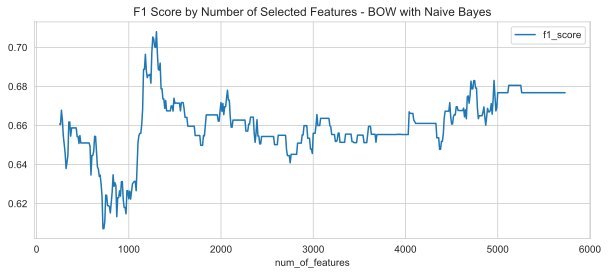

In [33]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [34]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
105,1300,0.71,0.71
101,1260,0.71,0.71
102,1270,0.70,0.71
103,1280,0.70,0.70
104,1290,0.70,0.70


#### Get a more fine-grained look at the optimal number of features region

In [35]:
rows = []
for i in range(950, 1050, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

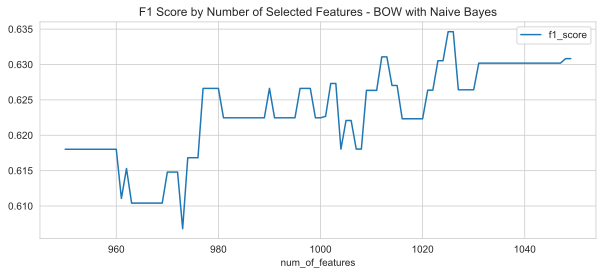

In [36]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [37]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
76,1026,0.63,0.64
75,1025,0.63,0.64
62,1012,0.63,0.64
63,1013,0.63,0.64
99,1049,0.63,0.64


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [38]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

1026

In [39]:
model_nb_bow_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bow_opt, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test)

In [40]:
print(cm_optimal)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11 14  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 13  3  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  5 15  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  4 21  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5 13  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  2  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  7 14 11  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  1  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  6  7]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  6]]


In [41]:
print(report_opt)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.80      0.42      0.55        19
 coffee-ordering-2       0.56      0.88      0.68        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.72      0.65      0.68        20
   movie-tickets-2       0.68      0.68      0.68        22
   movie-tickets-3       0.78      0.88      0.82        24
  pizza-ordering-1       0.47      0.64      0.55        14
  pizza-ordering-2       0.72      0.57      0.63        23
restaurant-table-1       0.75      0.41      0.53        22
restaurant-table-2       0.44      0.82      0.57        17
restaurant-table-3       0.36      0.25      0.30        16
       uber-lyft-1       0.46      0.40      0.43        15
       uber-lyft-2       0.40      0.46      0.43        13

          accuracy                           0.64       250
         macro avg       0.65      0.6

In [42]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.62,0.62
1,BOW Naive Bayes All Features,0.68,0.69
2,BOW Naive Bayes Optimal Features Selected: 960,0.63,0.64


---

## Bag of N-Grams

## Bag of N-Grams Feature Extraction

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(doc_lst)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [46]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,aaa ok,abbey drive,able accommodate,able add,able besides,able book,able complete,able get,able go,able handle,able indoor,able later,able make,able moshiato,able pick,...,zipcode theatres,zipcode would,ziti available,zone way,zoo also,zoo need,zoo philly,zoo picked,zoo ppg,zoo specific,zoo today,zoo wahpeton,zoo would,zz sounds,zz zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(750, 36597)
(250, 36597)
(250,)


## Bag of N-Grams Features Baseline Benchmarking with LinearSVC Classifier

In [48]:
from sklearn.svm import LinearSVC

model_svc_bong = LinearSVC()
cm_svc_bong, pred_svc_bong, f1_svc_bong, report_svc_bong, accuracy_svc_bong = Build_Model(model_svc_bong, X_train_bong, y_train, X_test_bong, y_test)

In [50]:
# Save benchmark output
rows_benchmarks.append(["Bag Of N-Grams LinearSVC All Features", f1_svc_bong, accuracy_svc_bong])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57


In [52]:
from sklearn.metrics import confusion_matrix

cm_svc_bong

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12,  6,  8,  3,  1,  2,  3,  2,  8,  1,  1,  3,  2],
       [ 0,  6, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 13,  7,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3, 11,  4,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  3, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  5,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  4, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  9,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  4,  3,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  8,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10]],
      dtype=int64)

In [53]:
print(accuracy_svc_bong)

0.568


In [54]:
from sklearn import metrics

print(report_svc_bong)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.23      0.63      0.34        19
 coffee-ordering-2       0.62      0.62      0.62        16
      movie-finder       1.00      0.27      0.43        11
   movie-tickets-1       0.62      0.65      0.63        20
   movie-tickets-2       0.58      0.50      0.54        22
   movie-tickets-3       0.80      0.67      0.73        24
  pizza-ordering-1       0.58      0.50      0.54        14
  pizza-ordering-2       0.75      0.65      0.70        23
restaurant-table-1       0.29      0.09      0.14        22
restaurant-table-2       0.41      0.53      0.46        17
restaurant-table-3       0.50      0.50      0.50        16
       uber-lyft-1       0.80      0.53      0.64        15
       uber-lyft-2       0.71      0.77      0.74        13

          accuracy                           0.57       250
         macro avg       0.64      0.5

#### Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [55]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
cm_nb_bong, pred_nb_bong, f1_nb_bong, report_nb_bong, accuracy_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [56]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes All Features", f1_nb_bong, accuracy_nb_bong])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67


In [57]:
from sklearn.metrics import confusion_matrix

cm_nb_bong

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2, 13,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  6, 12,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  2, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 18,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0, 15, 17,  9,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  7,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 11]],
      dtype=int64)

In [58]:
from sklearn import metrics

print(report_nb_bong)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.79      0.58      0.67        19
 coffee-ordering-2       0.62      0.81      0.70        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.57      0.65      0.60        20
   movie-tickets-2       0.50      0.55      0.52        22
   movie-tickets-3       0.81      0.71      0.76        24
  pizza-ordering-1       0.62      0.57      0.59        14
  pizza-ordering-2       0.75      0.78      0.77        23
restaurant-table-1       1.00      0.27      0.43        22
restaurant-table-2       0.40      1.00      0.58        17
restaurant-table-3       0.70      0.44      0.54        16
       uber-lyft-1       0.90      0.60      0.72        15
       uber-lyft-2       0.65      0.85      0.73        13

          accuracy                           0.67       250
         macro avg       0.74      0.6

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

#### Iterate through number of features and get benchmark results

In [60]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

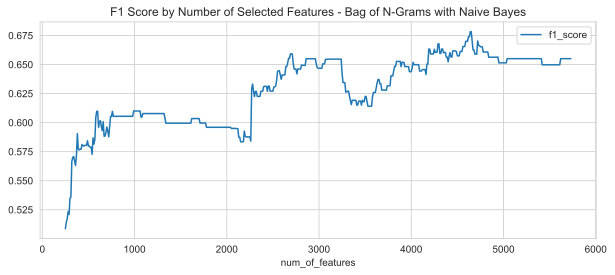

In [61]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [62]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
439,4640,0.68,0.68
440,4650,0.68,0.68
438,4630,0.67,0.67
437,4620,0.67,0.67
447,4720,0.67,0.67


#### Get a more fine-grained look at the optimal number of features region

In [63]:
rows = []
for i in range(4600, 4750, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

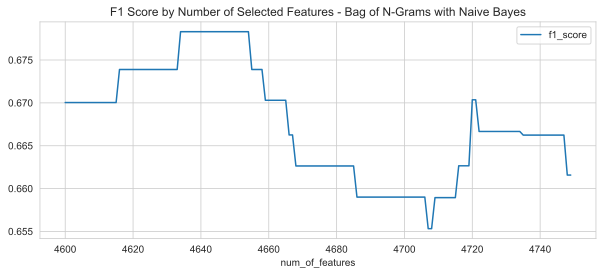

In [64]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [65]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
50,4650,0.68,0.68
53,4653,0.68,0.68
35,4635,0.68,0.68
36,4636,0.68,0.68
37,4637,0.68,0.68


#### Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [66]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

4650

In [67]:
model_nb_bong_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test)

In [68]:
print(cm_optimal)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9 12  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2 15  8  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 12  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2 17  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6 17  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  2  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 12 14  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5 11]]


In [69]:
print(report_opt)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.71      0.53      0.61        19
 coffee-ordering-2       0.57      0.75      0.65        16
      movie-finder       1.00      0.82      0.90        11
   movie-tickets-1       0.58      0.75      0.65        20
   movie-tickets-2       0.57      0.55      0.56        22
   movie-tickets-3       0.85      0.71      0.77        24
  pizza-ordering-1       0.57      0.57      0.57        14
  pizza-ordering-2       0.74      0.74      0.74        23
restaurant-table-1       0.82      0.41      0.55        22
restaurant-table-2       0.39      0.82      0.53        17
restaurant-table-3       0.78      0.44      0.56        16
       uber-lyft-1       0.83      0.67      0.74        15
       uber-lyft-2       0.69      0.85      0.76        13

          accuracy                           0.68       250
         macro avg       0.72      0.6

In [71]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68


---

## TF-IDF Feature Extraction

In [72]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 4998)
(250, 4998)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [73]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Make Some Predictions

In [74]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 4998)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [75]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 16,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5, 18,  7,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 11,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  4, 20,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7, 17,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20, 17, 14,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 11]],
      dtype=int64)

In [76]:
from sklearn import metrics

print(report_nb_tfidf)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.44      1.00      0.62        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.58      0.90      0.71        20
   movie-tickets-2       0.69      0.50      0.58        22
   movie-tickets-3       0.69      0.83      0.75        24
  pizza-ordering-1       0.54      0.50      0.52        14
  pizza-ordering-2       0.71      0.74      0.72        23
restaurant-table-1       1.00      0.05      0.09        22
restaurant-table-2       0.33      1.00      0.50        17
restaurant-table-3       0.67      0.12      0.21        16
       uber-lyft-1       0.88      0.93      0.90        15
       uber-lyft-2       0.92      0.85      0.88        13

          accuracy                           0.61       250
         macro avg       0.60      0.6

In [77]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61


In [78]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes Multinomial

In [79]:
rows = []
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\C

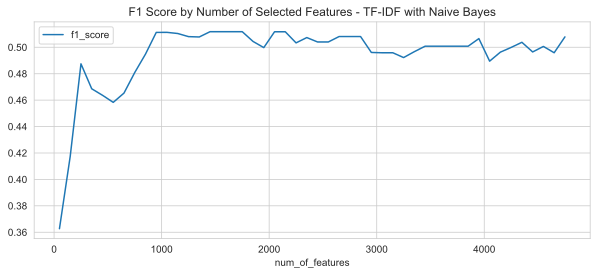

In [80]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [81]:
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
14,1450,0.51,0.57
17,1750,0.51,0.57
16,1650,0.51,0.57
15,1550,0.51,0.57
21,2150,0.51,0.57


#### Take closer look at region around 1150 features

In [82]:
rows = []
for i in range(1150, 1250, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\C

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\C

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\C

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


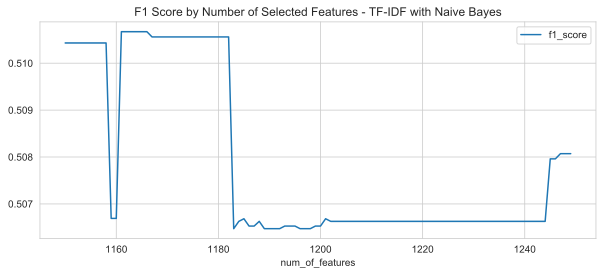

In [83]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [84]:
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
16,1166,0.51,0.57
15,1165,0.51,0.57
14,1164,0.51,0.57
13,1163,0.51,0.57
12,1162,0.51,0.57


#### Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [85]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, 1216, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: 1115", f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.51,0.57


## TF-IDF Benchmarking with LinearSVC

In [86]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

model_svc_tfidf = LinearSVC()
cm_svc_tfidf, pred_svc_tfidf, f1_svc_tfidf, report_svc_tfidf, accuracy_svc_tfidf = Build_Model(model_svc_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Show Confusion Matrix Heat Map for TF-IDF LinearSVC baseline

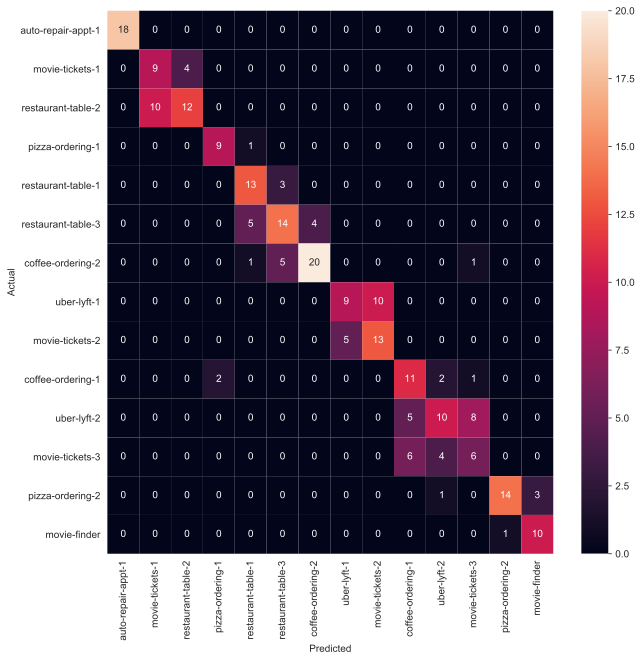

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svc_tfidf, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Confusion Matrix for Linear SVC on TF-IDF features

In [88]:
cm_svc_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  9,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 14,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  5, 20,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 13,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0, 11,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 10,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  4,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0, 14,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 10]],
      dtype=int64)

#### Metrics For Each Class

In [89]:
from sklearn import metrics
print(report_svc_tfidf)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.69      0.47      0.56        19
 coffee-ordering-2       0.55      0.75      0.63        16
      movie-finder       0.90      0.82      0.86        11
   movie-tickets-1       0.81      0.65      0.72        20
   movie-tickets-2       0.61      0.64      0.62        22
   movie-tickets-3       0.74      0.83      0.78        24
  pizza-ordering-1       0.47      0.64      0.55        14
  pizza-ordering-2       0.72      0.57      0.63        23
restaurant-table-1       0.69      0.50      0.58        22
restaurant-table-2       0.43      0.59      0.50        17
restaurant-table-3       0.38      0.38      0.38        16
       uber-lyft-1       0.78      0.93      0.85        15
       uber-lyft-2       0.91      0.77      0.83        13

          accuracy                           0.67       250
         macro avg       0.69      0.6

In [90]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF LinearSVC All Features", f1_svc_tfidf, accuracy_svc_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.51,0.57
7,TF-IDF LinearSVC All Features,0.67,0.67


## Word2Vec Feature Extraction

In [91]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['described', 'rope', 'hook', 'fix', 'honda'],
 'pizza': ['toppings', 'ham', 'large', 'tomato', 'u'],
 'terminator': ['judgment', 'abyss', 'avatar', 'sigourney', 'weaver'],
 'star': ['wars', 'previous', 'return', 'jedi', 'blade'],
 'audi': ['powers', 'weird', 'q', 'drives', 'apppointment'],
 'east': ['yo', 'broad', 'malleys', 'twono', 'intercontinental'],
 'korean': ['bbgo', 'lauderhill', 'manna', 'pig', 'bbq'],
 'playing': ['friend', 'shazam', 'flick', 'mills', 'early']}

#### Visualizing word embeddings

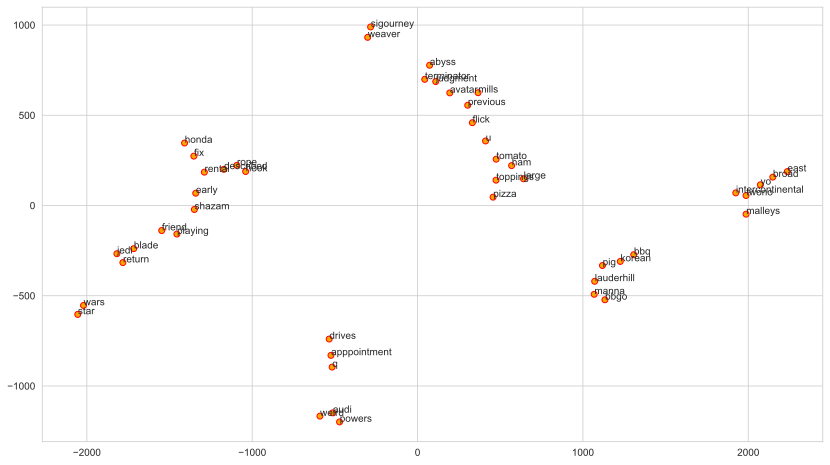

In [92]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [93]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [94]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [95]:
w2v_model.wv['jedi']

array([-0.5687543 , -0.21585965, -0.19750029, -0.53021824,  0.35802296,
       -0.2404899 , -0.4963517 , -0.14356445, -0.2110142 ,  0.61847365,
        0.3046614 , -0.16961324,  0.96650285,  0.03666557, -0.2163316 ,
       -0.21458393, -0.3949615 ,  0.06733088,  0.3948887 ,  0.3063328 ,
        0.6921569 ,  0.2804018 , -0.21131209, -0.7299792 ,  0.9784385 ,
       -0.06471738, -0.19878444, -0.46755514,  0.00318726, -0.37325037,
        0.1805604 , -0.06696926,  0.24538518, -0.308489  , -0.4018399 ,
       -0.08629844,  0.16412584, -0.37520492,  0.28785318,  0.04262436,
        0.30001795,  0.08943062, -0.16468334,  0.01965695,  0.8900363 ,
       -0.4328633 , -0.3858431 ,  0.15568864,  0.72225565, -0.19584154,
       -0.5189732 , -0.14059074,  0.6236167 , -0.2907619 , -0.3305957 ,
        0.1573138 ,  0.05692289,  0.01932582,  0.85262614, -0.299744  ,
        0.27275202,  0.29817638, -0.39043427, -0.50763863, -0.17783538,
        0.06756787, -0.00186566, -0.48915735,  0.6863593 , -0.25

#### Build framework for getting document level embeddings

In [96]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [97]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.27,0.80,1.19,0.39,-1.38,-0.31,-0.09,0.13,0.00,-0.14,0.03,0.55,-0.36,0.39,-0.00,...,0.32,0.23,-0.52,0.02,0.23,-0.83,0.56,-0.35,0.17,-0.06,1.22,0.37,-0.31,0.05,-0.40
1,0.58,-0.24,0.54,0.07,0.75,-0.50,-0.95,-0.18,-0.32,-0.17,0.98,-0.96,0.20,0.40,-0.16,...,0.78,-0.33,-0.25,-0.33,-0.12,0.26,-0.83,0.17,-0.30,-0.06,-0.43,0.25,-0.52,-0.79,-0.07
2,0.69,-0.37,0.47,-0.81,0.95,-0.45,0.13,-0.43,-0.73,0.08,0.25,-1.14,0.62,0.25,-0.16,...,0.06,0.47,0.09,0.05,-0.24,0.21,0.24,-0.28,0.40,-0.24,-0.02,-0.14,-0.42,-0.85,-0.27
3,0.41,-0.11,-0.27,0.04,-0.32,0.15,0.25,-0.33,0.44,-0.29,0.60,-1.01,-0.42,0.13,-0.22,...,0.41,0.69,-0.33,-0.89,0.37,-0.37,0.11,1.01,0.17,0.44,0.28,0.35,-0.33,-0.78,-0.07
4,-0.23,0.16,-0.59,0.13,-1.13,0.41,1.29,0.62,0.23,0.01,-0.20,-0.68,-0.28,-0.20,-0.30,...,-0.13,1.17,-0.46,-0.18,0.21,-0.67,0.75,0.59,0.62,-0.37,0.86,-0.25,-0.20,-0.90,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,1.12,0.24,1.25,-0.90,0.28,-0.57,0.15,-0.33,-0.83,0.49,0.26,-0.63,0.97,-0.02,-0.04,...,0.23,1.15,-0.38,0.87,-0.46,0.01,1.01,-0.40,0.58,-0.44,0.36,-0.99,-0.89,-1.09,-0.20
746,0.61,-0.06,0.04,-1.02,-0.14,-0.25,0.63,0.42,0.53,0.34,0.20,-0.52,-0.07,0.11,0.13,...,-0.19,0.67,0.29,-0.28,0.72,0.62,0.50,-0.18,0.94,-0.58,0.53,-0.32,-1.02,0.35,-0.03
747,0.59,-0.90,0.16,-1.01,0.55,-0.71,1.20,0.37,-0.74,-0.79,0.49,-0.72,0.01,0.14,0.25,...,-0.15,0.82,0.23,0.08,-0.39,-0.14,1.05,0.46,1.07,-0.58,-0.21,-0.13,-0.64,-0.93,-0.56
748,0.33,-0.40,-0.17,0.03,-0.30,0.17,0.20,-0.35,0.30,-0.15,0.69,-1.51,0.07,0.65,-0.35,...,0.22,0.87,-0.27,-1.02,0.20,-0.16,0.24,0.40,0.88,0.10,0.07,0.35,-0.56,-0.61,-0.09


In [98]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


## Word2vec Feature Benchmarking with GaussianNB Classifier

In [99]:
from sklearn.naive_bayes import GaussianNB

#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes All Features", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.51,0.57
7,TF-IDF LinearSVC All Features,0.67,0.67
8,Word2Vec Naive Bayes All Features,0.65,0.67


In [100]:
cm_nb_w2v

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 17, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  4,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3, 14,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  4, 20,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  9,  5,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8, 10,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  2, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  8]],
      dtype=int64)

In [101]:
print(report_nb_w2v)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.11      0.19        19
 coffee-ordering-2       0.48      1.00      0.65        16
      movie-finder       0.91      0.91      0.91        11
   movie-tickets-1       0.75      0.75      0.75        20
   movie-tickets-2       0.70      0.64      0.67        22
   movie-tickets-3       0.80      0.83      0.82        24
  pizza-ordering-1       0.53      0.71      0.61        14
  pizza-ordering-2       0.78      0.61      0.68        23
restaurant-table-1       0.56      0.41      0.47        22
restaurant-table-2       0.50      0.59      0.54        17
restaurant-table-3       0.65      0.81      0.72        16
       uber-lyft-1       0.62      0.53      0.57        15
       uber-lyft-2       0.53      0.62      0.57        13

          accuracy                           0.67       250
         macro avg       0.70      0.6

In [102]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


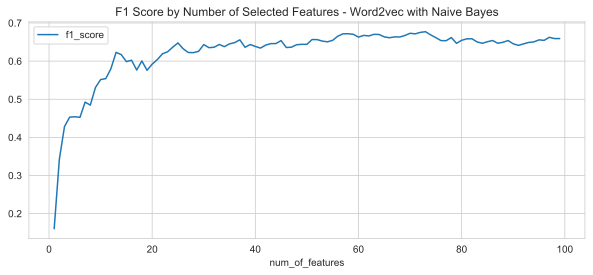

In [103]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [104]:
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
72,73,0.68,0.68
71,72,0.68,0.68
69,70,0.67,0.68
57,58,0.67,0.68
56,57,0.67,0.68


In [105]:
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 97, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes Optimal Features Selected: 97", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.51,0.57
7,TF-IDF LinearSVC All Features,0.67,0.67
8,Word2Vec Naive Bayes All Features,0.65,0.67
9,Word2Vec Naive Bayes Optimal Features Selected: 97,0.66,0.68


## Word2vec Feature Benchmarking with LinearSVC Classifier

In [106]:
from sklearn.svm import LinearSVC

model_w2v = LinearSVC()
cm_svc_w2v, pred_svc_w2v, f1_svc_w2v, report_svc_w2v, accuracy_svc_w2v = Build_Model(model_w2v, w2v_feature_array, y_train, w2v_test_array, y_test)

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [107]:
from sklearn.metrics import confusion_matrix

cm_svc_w2v

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 17,  3,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  2,  2, 20,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9, 10,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 13,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0, 12,  5,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 10,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  1, 11,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0, 11,  5],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  4,  7]],
      dtype=int64)

In [108]:
from sklearn import metrics
print(report_svc_w2v)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.79      0.58      0.67        19
 coffee-ordering-2       0.62      0.81      0.70        16
      movie-finder       1.00      0.82      0.90        11
   movie-tickets-1       0.75      0.60      0.67        20
   movie-tickets-2       0.65      0.77      0.71        22
   movie-tickets-3       0.80      0.83      0.82        24
  pizza-ordering-1       0.47      0.64      0.55        14
  pizza-ordering-2       0.72      0.57      0.63        23
restaurant-table-1       0.57      0.55      0.56        22
restaurant-table-2       0.59      0.59      0.59        17
restaurant-table-3       0.65      0.69      0.67        16
       uber-lyft-1       0.65      0.73      0.69        15
       uber-lyft-2       0.58      0.54      0.56        13

          accuracy                           0.69       250
         macro avg       0.70      0.6

In [109]:
# Save benchmark output
rows_benchmarks.append(["Word2vec LinearSVC All Features", f1_svc_w2v, accuracy_svc_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.51,0.57
7,TF-IDF LinearSVC All Features,0.67,0.67
8,Word2Vec Naive Bayes All Features,0.65,0.67
9,Word2Vec Naive Bayes Optimal Features Selected: 97,0.66,0.68


## Feature Selection - Word2vec with LinearSVC

In [110]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_svc_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pauld\Anaconda3\envs\C

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

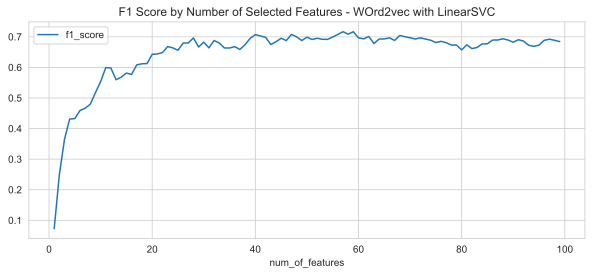

In [111]:
sel_svc_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - WOrd2vec with LinearSVC", figsize=(10, 4))

In [112]:
sel_svc_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
56,57,0.72,0.72
58,59,0.72,0.72
57,58,0.71,0.71
46,47,0.71,0.71
55,56,0.71,0.71


In [115]:
cm_w2v_svc, pred_w2v_svc, f1_w2v_svc, report_w2v_svc, accuracy_w2v_svc = SelectBestModelFeatures_Chi(model_w2v, 57, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec LinearSVC Optimal Features Selected: 53", f1_w2v_svc, accuracy_w2v_svc])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

C:\Users\pauld\Anaconda3\envs\CP\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Features_Benchedmarked,f1_score,accuracy
0,Bag Of N-Grams LinearSVC All Features,0.57,0.57
1,Bag Of N-Grams LinearSVC All Features,0.57,0.57
2,Bag of N-Gram Naive Bayes All Features,0.67,0.67
3,BOW Naive Bayes Optimal Features Selected: 960,0.68,0.68
4,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.68,0.68
5,TF-IDF Naive Bayes All Features,0.54,0.61
6,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.51,0.57
7,TF-IDF LinearSVC All Features,0.67,0.67
8,Word2Vec Naive Bayes All Features,0.65,0.67
9,Word2Vec Naive Bayes Optimal Features Selected: 97,0.66,0.68


In [116]:
print(report_w2v_svc)

                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.93      0.68      0.79        19
 coffee-ordering-2       0.71      0.94      0.81        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.71      0.75      0.73        20
   movie-tickets-2       0.64      0.64      0.64        22
   movie-tickets-3       0.83      0.83      0.83        24
  pizza-ordering-1       0.56      0.64      0.60        14
  pizza-ordering-2       0.76      0.70      0.73        23
restaurant-table-1       0.57      0.55      0.56        22
restaurant-table-2       0.59      0.59      0.59        17
restaurant-table-3       0.53      0.56      0.55        16
       uber-lyft-1       0.69      0.60      0.64        15
       uber-lyft-2       0.60      0.69      0.64        13

          accuracy                           0.72       250
         macro avg       0.72      0.7

## Additional Advanced Methods To Explore Further

#### GloVe Embeddings with spaCy

In [118]:
import spacy

#nlp = spacy.load('en_vectors_web_lg')
nlp = spacy.load('en_vecs')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [119]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
awayits,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
groups,-0.15,0.03,-0.15,0.15,0.26,-0.11,-0.43,0.33,0.36,2.69,-0.67,-0.32,0.14,-0.25,0.33,...,0.18,0.66,0.01,0.42,0.36,-0.14,-0.15,0.19,-0.07,-0.34,0.17,0.02,-0.15,-0.03,0.46
believe,-0.29,0.34,-0.37,-0.10,-0.00,0.04,-0.02,0.10,0.07,3.02,-0.16,-0.03,0.38,0.31,-0.47,...,-0.02,0.04,-0.14,0.25,0.17,-0.30,0.03,-0.34,-0.04,0.23,-0.08,-0.56,0.05,0.48,0.02
georges,-0.41,0.24,0.08,-0.37,0.40,0.50,0.27,0.02,0.29,-0.55,-0.15,-0.20,0.12,-0.53,-0.49,...,0.53,0.59,-0.20,-0.48,-0.65,1.05,-0.31,-0.37,-0.20,0.65,0.06,0.26,-0.14,0.06,0.08
sister,0.00,-0.13,-0.47,0.24,0.26,-0.50,0.53,-0.64,-0.07,2.76,-0.31,0.54,0.03,-0.35,-0.42,...,0.65,0.07,-0.03,-0.10,0.11,0.28,0.01,-0.02,0.61,0.23,-0.22,0.09,-0.04,0.11,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cars,0.54,0.19,-0.05,-0.49,0.34,-0.03,-0.15,0.03,-0.27,1.96,-0.19,0.07,-0.17,0.10,-0.81,...,0.40,0.12,-0.68,-0.59,-0.27,-1.47,-0.82,0.76,-0.56,0.05,-0.46,0.20,-0.03,0.22,0.33
downstairs,0.76,-0.47,0.01,-0.14,-0.02,0.04,-0.01,-1.00,0.10,1.53,0.08,-0.06,-0.24,-0.09,-0.15,...,0.43,0.47,0.37,-0.38,0.48,0.01,-0.36,0.52,0.70,-0.16,0.81,0.32,0.20,0.19,-0.14
extras,0.13,-0.53,0.17,-0.35,-0.18,0.25,-0.22,-0.62,-0.17,0.53,0.09,0.08,0.30,0.00,0.42,...,-0.04,-0.47,0.01,-0.12,-0.11,-0.97,-0.15,-0.24,0.09,0.27,-0.18,-0.09,-0.50,0.05,-0.22
questions,-0.31,0.20,-0.28,0.33,0.06,-0.02,0.17,0.25,0.39,2.52,-0.30,-0.58,0.46,-0.35,-0.32,...,-0.09,-0.07,0.11,-0.57,0.15,-0.07,0.02,-0.34,-0.18,0.44,-0.31,-0.15,-0.11,0.52,0.31


In [120]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5014, 300)


#### Word2vec features with Fastext Model

In [121]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [122]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['coffees', 'papillon', 'arent', 'id', 'pie'],
 'pizza': ['pepperoni', 'large', 'crust', 'toppings', 'sausage'],
 'terminator': ['nevermind', 'destination', 'company', 'daughter', 'tip'],
 'star': ['wars', 'recommendations', 'rating', 'episode', 'older'],
 'audi': ['menu', 'old', 'vegetarian', 'smith', 'fresh'],
 'east': ['atlanta', 'oak', 'middle', 'river', 'fact'],
 'korean': ['belt', 'bbq', 'alex', 'p', 'cannot'],
 'playing': ['tickets', 'movie', 'theater', 'showing', 'theaters']}

#### PCA on Fasttext Model

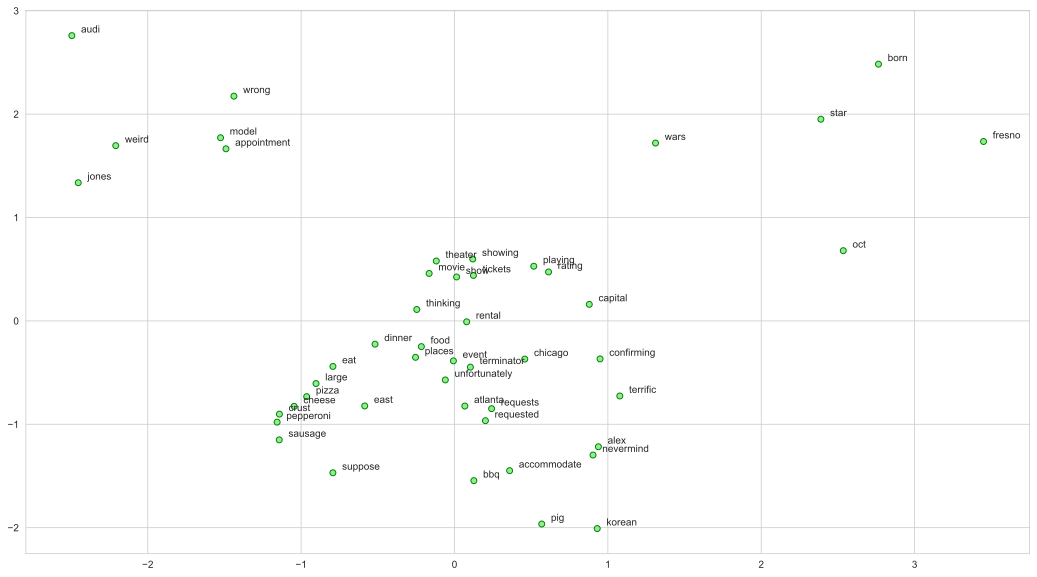

In [55]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [56]:
ft_model.wv['rental']

array([-0.2456603 , -0.3847549 ,  0.06492562,  0.04740023, -0.05075805,
       -0.22694312,  0.4215116 , -0.33982405, -0.04370858,  0.0629853 ,
       -0.3409566 ,  0.00812502, -0.0774149 ,  0.48186895,  0.21284053,
        0.3371108 , -0.25463784, -0.17870781,  0.18154614, -0.40187714,
       -0.11597514,  0.06976771, -0.2827826 ,  0.34207228,  0.11847469,
        0.09189652,  0.4980718 , -0.389526  , -0.03210843, -0.16801834,
       -0.6243001 ,  0.18326154,  0.2597041 , -0.03512648, -0.03855328,
       -0.23020533, -0.21311814,  0.24731663, -0.12095507,  0.21898097,
       -0.03530402,  0.11089047,  0.38267976, -0.03408687,  0.47464603,
        0.13449542,  0.16546832, -0.0557306 , -0.17744146, -0.08903551,
       -0.1279476 , -0.05045699,  0.1012897 , -0.2515585 , -0.06074018,
        0.3012346 ,  0.2712584 ,  0.00910348, -0.2822897 ,  0.10751042,
        0.1602443 ,  0.05004477, -0.39422616, -0.19322552,  0.03605143,
       -0.2429987 , -0.26940596, -0.05992399, -0.18235217, -0.04

In [57]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.103287175
0.7937065


In [58]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
